In [1]:
#Import 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil

In [220]:
#Read
base = 'batches/output'
exps = os.listdir(base) #list of video instances trained

#Example instance name format {UVGname}_sbatch_test_out_{qtm}_{qte}

In [59]:
#Parse
inst = []

for i in exps:
    
    #Split first then store
    try:
        name,_,_,_,qtm,qte = i.split('_')
    except:
        print("Warning! Current code here does not catch all Experiments! Check me!")
        print(">> Problem with:")
        print("   >> {}".format(i))
        continue
        
    inst.append({
        'UVG_name':name,
        'inst_name':'_'.join([name,qtm,qte]),
        'quant_factor_model':qtm,
        'quant_factor_embed':qte,
        'path': os.path.join(os.getcwd(),base,i)
    })

Warning! Current code here does not catch all Experiments! Check me!
>> Problem with:
   >> beauty_sbatch_BS2_test_out_8_6


In [60]:
inst[:1]

[{'UVG_name': 'beauty',
  'inst_name': 'beauty_4_12',
  'quant_factor_model': '4',
  'quant_factor_embed': '12',
  'path': '/scratch/kl3866/IVP/HNeRV/batches/output/beauty_sbatch_test_out_4_12'}]

In [27]:
#Go through each folder and copy and rename them
target_dir = 'compiled_out'
target_dir = os.path.join(os.getcwd(),'batches',target_dir)
print(target_dir)

/scratch/kl3866/IVP/HNeRV/batches/compiled_out


In [63]:
#Loop thorugh each instance
for i in inst:
    
    #Unpack
    inst_name = i['inst_name']
    qte,qtm = i['quant_factor_embed'],i['quant_factor_embed']
    ori_path = i['path']
    name_1 = os.listdir(ori_path)[0] #need to dive in 2 layers more due to struct of hnerv output
    name_2 = os.listdir(os.path.join(ori_path,name_1))[0]
    ori_path = os.path.join(ori_path,name_1,name_2) #ugly but works, final dir
    
    #To copy
    target_path = os.path.join(target_dir,inst_name)
    if not os.path.isdir(target_path): os.makedirs(target_path) #create dir if not exist yet
            
    ###Copy
    #Quantized images
    src = os.path.join(ori_path,'visualize_model_quant')
    tgt = os.path.join(target_path,'pred_imgs_quantized')
    shutil.copytree(src,tgt)
    
    #Raw pred images
    src = os.path.join(ori_path,'visualize_model_orig')
    tgt = os.path.join(target_path,'pred_imgs_raw')
    shutil.copytree(src,tgt)
    
    #Metadata csv
    src = os.path.join(ori_path,'epoch300.csv') #CHANGE ME WHEN EPOCH CHANGES
    tgt = os.path.join(target_path,'metadata_{}.csv'.format(inst_name))
    shutil.copy(src,tgt)


_____

In [210]:
#Read all csv and concat before outputing
agg_df = []

#Misc vars 
inst_name_ = []
uvg_name_ = []
qtm_ = []
qte_ = []
PSNR_avg = []
for idx,i in enumerate(inst):
    
    #Unpack
    inst_name = i['inst_name']
    qte,qtm = i['quant_factor_embed'],i['quant_factor_model']
    ori_path = i['path']
    name_1 = os.listdir(ori_path)[0] #need to dive in 2 layers more due to struct of hnerv output
    name_2 = os.listdir(os.path.join(ori_path,name_1))[0]
    ori_path = os.path.join(ori_path,name_1,name_2) #ugly but works, final dir
    

    #Metadata csv
    temp = pd.read_csv(os.path.join(ori_path,'epoch300.csv'),index_col=0)
    psnr_ls = temp.PSNR_list_50.values[0].split(',')
    psnr_ls = [float(i) for i in psnr_ls]
    
    inst_name_.append(inst_name)
    uvg_name_.append(i['UVG_name'])
    qtm_.append(qtm)
    qte_.append(qte)
    PSNR_avg.append(np.mean(psnr_ls))
    
    agg_df.append(temp)

In [211]:
#Concat
agg_df = pd.concat(agg_df)
agg_df.reset_index(inplace=True)
agg_df.drop(['index','Vid'],axis=1,inplace=True)

#Insert cols
agg_df['QTE'] = qte_
agg_df['QTM'] = qtm_
agg_df['Avg PSNR'] = PSNR_avg
agg_df['UVG Video Src'] = uvg_name_
agg_df['Instance Name'] = inst_name_


#Rearrange
cols = agg_df.columns
cols = list(cols[-2:]) + list(cols[:-2])
agg_df = agg_df[cols]

agg_df.head()

,UVG Video Src,Instance Name,CurEpoch,Train Time,Compression Method,Compression Encoding Time,Compression Decoding Time,"FPS (Quantized, Full Pass)","FPS (Quantized, Forward Pass)","FPS (Full Model, Full Pass)",...,best_quant_seen_ssim,best_quant_unseen_psnr,best_quant_unseen_ssim,pred_seen_psnr,pred_seen_ssim,pred_unseen_psnr,pred_unseen_ssim,QTE,QTM,Avg PSNR
0,beauty,beauty_4_12,300,0:15:46.966341,huffman,0.066010,1.515363,7.431577,8.273401,5.942822,...,0.8122,0.0,0.0,26.68,0.8282,0.0,0.0,12,4,24.62875
1,beauty,beauty_32_2,300,0:15:48.059199,huffman,0.063780,0.667142,7.337985,8.157002,5.973090,...,0.8118,0.0,0.0,29.51,0.8811,0.0,0.0,2,32,28.48875
2,honeybee,honeybee_8_6,300,0:16:27.578649,huffman,0.066114,2.625243,7.316381,8.130655,5.910132,...,0.9617,0.0,0.0,30.79,0.9619,0.0,0.0,6,8,29.19875
3,bosphorus,bosphorus_8_18,300,0:15:44.278635,huffman,0.066761,2.684422,7.369738,8.197916,5.943723,...,0.8503,0.0,0.0,27.32,0.8507,0.0,0.0,18,8,26.63125
4,beauty,beauty_8_6,300,0:15:48.099681,huffman,0.065990,2.656368,7.357512,8.183621,5.911819,...,0.8164,0.0,0.0,26.08,0.8214,0.0,0.0,6,8,24.34250


In [212]:
#Save out
agg_df.to_csv('hnerv_agg_results.csv')

In [213]:
#Quick viz
beauty = agg_df.loc[agg_df['UVG Video Src'] == 'beauty']

<AxesSubplot:xlabel='bits/pixel', ylabel='Avg PSNR'>

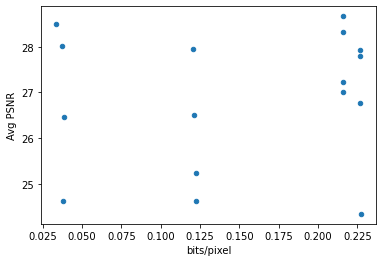

In [215]:
beauty[['Avg PSNR','bits/pixel']].plot.scatter(y='Avg PSNR',x='bits/pixel')

<AxesSubplot:xlabel='best_quant_seen_psnr', ylabel='best_pred_seen_psnr'>

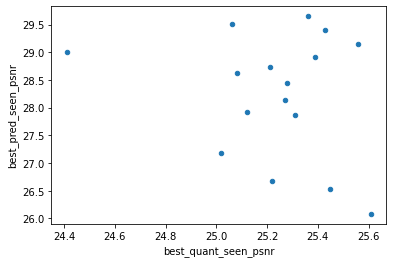

In [181]:
beauty[['best_pred_seen_psnr','best_quant_seen_psnr']].plot.scatter(y='best_pred_seen_psnr',x='best_quant_seen_psnr')

<AxesSubplot:xlabel='QTE', ylabel='best_quant_seen_psnr'>

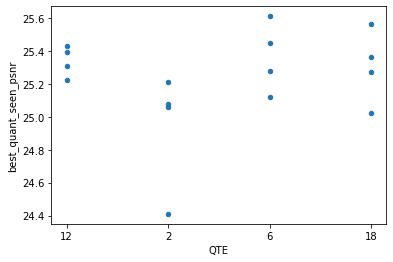

In [182]:
beauty[['best_quant_seen_psnr','QTE']].plot.scatter(y='best_quant_seen_psnr',x='QTE')

<AxesSubplot:xlabel='QTM', ylabel='best_quant_seen_psnr'>

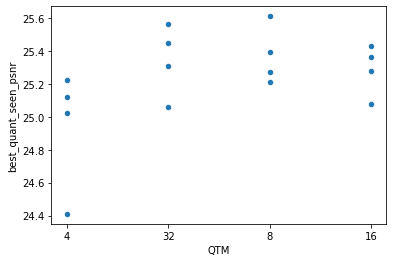

In [183]:
beauty[['best_quant_seen_psnr','QTM']].plot.scatter(y='best_quant_seen_psnr',x='QTM')

<AxesSubplot:xlabel='QTM', ylabel='bits/pixel'>

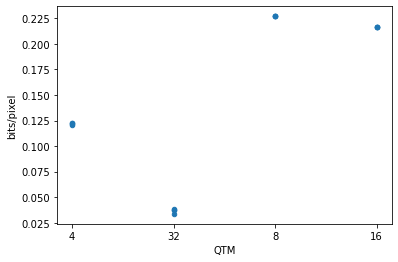

In [184]:
beauty[['bits/pixel','QTM']].plot.scatter(y='bits/pixel',x='QTM')

<AxesSubplot:xlabel='QTE', ylabel='bits/pixel'>

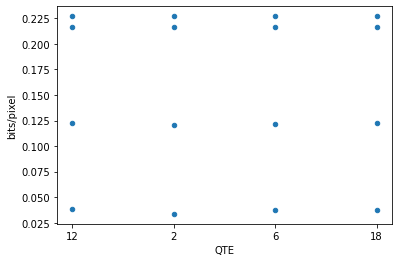

In [185]:
beauty[['bits/pixel','QTE']].plot.scatter(y='bits/pixel',x='QTE')

In [186]:
#Isolate individual level

    Avg PSNR  bits/pixel QTE QTM
1   28.48875    0.033647   2  32
7   27.79125    0.226899   2   8
23  27.22000    0.216121   2  16
26  27.95500    0.120359   2   4
    Avg PSNR  bits/pixel QTE QTM
4   24.34250    0.227005   6   8
20  24.63125    0.037952   6  32
38  26.51125    0.121503   6   4
44  27.01625    0.216123   6  16
    Avg PSNR  bits/pixel QTE QTM
15  28.66625    0.216051  18  16
18  25.24625    0.122612  18   4
24  28.02250    0.037519  18  32
36  26.76250    0.226939  18   8
    Avg PSNR  bits/pixel QTE QTM
0   24.62875    0.122511  12   4
16  27.93125    0.226982  12   8
29  26.46500    0.038759  12  32
46  28.32500    0.216078  12  16


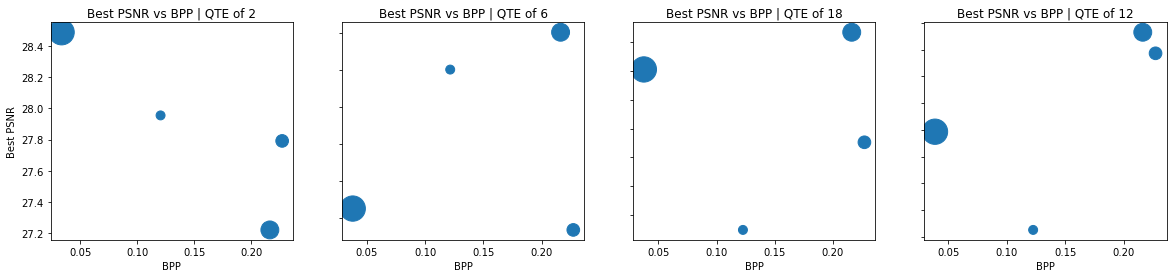

In [218]:
set_qte = list(set(qte_))
ct = len(set_qte)
fig, axs = plt.subplots(1, ct, figsize=(20,4))

for idx,i in enumerate(set_qte):
    temp = beauty[['Avg PSNR','bits/pixel','QTE','QTM']]
    temp = temp.loc[temp.QTE == i]
    
    print(temp)
    axs[idx].scatter(y=temp['Avg PSNR'],x=temp['bits/pixel'],s=temp['QTM'].astype(int)*20)
    axs[idx].set_title('Best PSNR vs BPP | QTE of {}'.format(i))

for ax in axs.flat:
    ax.set(xlabel='BPP', ylabel='Best PSNR')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

    Avg PSNR  bits/pixel QTE QTM
1   28.48875    0.033647   2  32
20  24.63125    0.037952   6  32
24  28.02250    0.037519  18  32
29  26.46500    0.038759  12  32
    Avg PSNR  bits/pixel QTE QTM
0   24.62875    0.122511  12   4
18  25.24625    0.122612  18   4
26  27.95500    0.120359   2   4
38  26.51125    0.121503   6   4
    Avg PSNR  bits/pixel QTE QTM
4   24.34250    0.227005   6   8
7   27.79125    0.226899   2   8
16  27.93125    0.226982  12   8
36  26.76250    0.226939  18   8
    Avg PSNR  bits/pixel QTE QTM
15  28.66625    0.216051  18  16
23  27.22000    0.216121   2  16
44  27.01625    0.216123   6  16
46  28.32500    0.216078  12  16


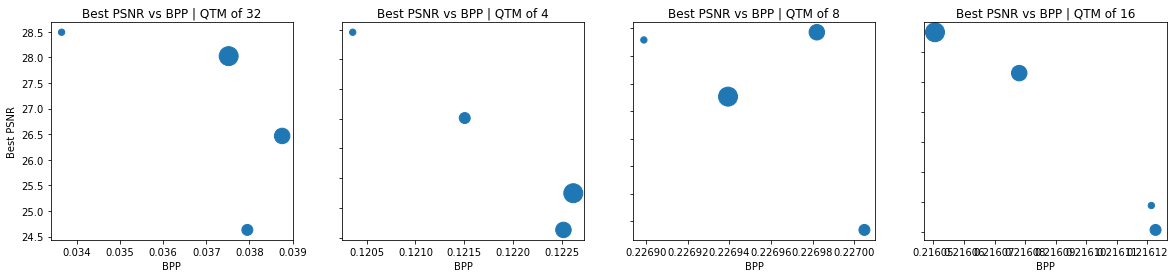

In [219]:
set_qtm = list(set(qtm_))
ct = len(set_qtm)
fig, axs = plt.subplots(1, ct, figsize=(20,4))

for idx,i in enumerate(set_qtm):
    temp = beauty[['Avg PSNR','bits/pixel','QTE','QTM']]
    temp = temp.loc[temp.QTM == i]
    
    print(temp)
    axs[idx].scatter(y=temp['Avg PSNR'],x=temp['bits/pixel'],s=temp['QTE'].astype(int)*20)
    axs[idx].set_title('Best PSNR vs BPP | QTM of {}'.format(i))

for ax in axs.flat:
    ax.set(xlabel='BPP', ylabel='Best PSNR')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [239]:
#Per paper
cols = ['UVG Video Src','QTE','QTM','bits/pixel','Avg PSNR','best_quant_seen_psnr','best_pred_seen_psnr','FPS (Full Model, Full Pass)','FPS (Quantized, Full Pass)']
default = agg_df.loc[(agg_df.QTM=='8') & (agg_df.QTE=='6')]

default[cols].sort_values('UVG Video Src')

,UVG Video Src,QTE,QTM,bits/pixel,Avg PSNR,best_quant_seen_psnr,best_pred_seen_psnr,"FPS (Full Model, Full Pass)","FPS (Quantized, Full Pass)"
4,beauty,6,8,0.227005,24.34250,25.61,26.08,5.911819,7.357512
6,bosphorus,6,8,0.226388,26.76000,27.19,27.53,5.891778,7.333042
2,honeybee,6,8,0.225731,29.19875,30.76,30.79,5.910132,7.316381


In [240]:
gamut = agg_df[cols]

gamut.groupby(by=['UVG Video Src']).mean().sort_values('UVG Video Src')

,bits/pixel,Avg PSNR,best_quant_seen_psnr,best_pred_seen_psnr,"FPS (Full Model, Full Pass)","FPS (Quantized, Full Pass)"
UVG Video Src,,,,,,
beauty,0.150441,26.875234,25.236250,28.240000,5.934176,7.341495
bosphorus,0.150349,26.912109,27.100000,27.754375,5.936019,7.345343
honeybee,0.149670,29.194688,30.464375,30.782500,5.938772,7.335489


In [241]:
gamut.groupby(by=['UVG Video Src']).min().sort_values('UVG Video Src')

,QTE,QTM,bits/pixel,Avg PSNR,best_quant_seen_psnr,best_pred_seen_psnr,"FPS (Full Model, Full Pass)","FPS (Quantized, Full Pass)"
UVG Video Src,,,,,,,,
beauty,12,16,0.033647,24.34250,24.41,26.08,5.813462,7.305546
bosphorus,12,16,0.037064,26.63000,26.67,27.32,5.891778,7.302916
honeybee,12,16,0.035321,29.17375,29.54,30.77,5.901741,7.296031


In [242]:
gamut.groupby(by=['UVG Video Src']).max().sort_values('UVG Video Src')

,QTE,QTM,bits/pixel,Avg PSNR,best_quant_seen_psnr,best_pred_seen_psnr,"FPS (Full Model, Full Pass)","FPS (Quantized, Full Pass)"
UVG Video Src,,,,,,,,
beauty,6,8,0.227005,28.66625,25.61,29.65,6.000248,7.431577
bosphorus,6,8,0.226388,27.82500,27.31,28.99,5.977123,7.397156
honeybee,6,8,0.225731,29.21500,30.78,30.80,6.023462,7.414666
